# Import Dependencies

In [ ]:
import os
import json
import random
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline
from scipy.stats import spearmanr
import statistics
import matplotlib.pyplot as plt
import seaborn as sns
import wandb

from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error

import numpy as np

from huggingface_hub import login
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
# Setup directories
os.makedirs("results", exist_ok=True)
os.makedirs("plots", exist_ok=True)



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 MB 19.2 MB/s eta 0:00:00


/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: areebamunir (areebamunir-nust) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

# Load Data

In [ ]:
with open("train.json", "r") as f:
    train_data = json.load(f)

with open("dev.json", "r") as f:
    dev_data = json.load(f)

# Load Model and tokenizer

In [ ]:
MODEL_NAME = "meta-llama/Llama-3.1-8B-Instruct"

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, token=HF_TOKEN)

# Load model in 4-bit
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    token=HF_TOKEN,
    device_map="auto",
    load_in_4bit=True,
    torch_dtype=torch.float16
)

print("Model loaded in 4-bit successfully!")


tokenizer_config.json:   0%|          | 0.00/55.4k [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/855 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!
The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/184 [00:00<?, ?B/s]

Model loaded in 4-bit successfully!


# Prompt Templte creation

In [ ]:
def build_zero_shot_prompt(sample):
    return f"""
{sample['precontext']} **{sample['sentence']}** {sample.get('ending','')}
In this context, how plausible is it that the meaning of the word "{sample['homonym']}" is "{sample['judged_meaning']}"?
Return only the numbered score (1,2,3,4,5)
"""


# Prediction

In [ ]:
def get_model_prediction(prompt):
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    with torch.no_grad():
        output = model.generate(**inputs, max_new_tokens=10)
    decoded = tokenizer.decode(output[0], skip_special_tokens=True)

    # Extract first integer 1-5 from model output
    for token in decoded.split():
        if token.isdigit() and 1 <= int(token) <= 5:
            return int(token)

    # fallback
    return 3

In [ ]:
def get_average(l):
    return sum(l)/len(l)

def get_standard_deviation(l):
    return statistics.stdev(l)

def is_within_standard_deviation(pred, labels):
    avg = get_average(labels)
    stdev = get_standard_deviation(labels)
    if (avg - stdev) <= pred <= (avg + stdev):
        return True
    if abs(avg - pred) < 1:
        return True
    return False

def evaluate(predictions, gold_data):
    gold_list, pred_list = [], []
    correct, total = 0, 0
    errors = []

    for id_str, pred in predictions.items():
        labels = gold_data[id_str]['choices']
        avg = get_average(labels)
        gold_list.append(avg)
        pred_list.append(pred)

        if is_within_standard_deviation(pred, labels):
            correct += 1
        else:
            errors.append((id_str, pred, avg))
        total += 1

    # Spearman correlation
    corr, p_val = spearmanr(pred_list, gold_list)
    accuracy = correct / total

    # MAE and MSE
    mae = mean_absolute_error(gold_list, pred_list)
    mse = mean_squared_error(gold_list, pred_list)

    print(f"Spearman correlation: {corr:.4f} (p={p_val:.4f})")
    print(f"Accuracy within SD: {accuracy:.4f} ({correct}/{total})")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Mean Squared Error (MSE): {mse:.4f}")

    return {
        'spearman': corr,
        'accuracy_within_std': accuracy,
        'mae': mae,
        'mse': mse,
        'errors': errors
    }

In [ ]:
def plot_corrections(errors, save_path=None, metrics=None):
    """
    Plots predicted vs gold averages for errors only.

    errors: list of tuples (id_str, pred, gold_avg)
    save_path: optional path to save the figure
    metrics: optional dict with spearman, accuracy, mae, mse to show in summary
    """
    if not errors:
        print("No errors to plot!")
        return

    preds = [e[1] for e in errors]
    golds = [e[2] for e in errors]

    fig, axes = plt.subplots(1, 2, figsize=(12, 6), dpi=300)

    # 1. Predictions vs Gold (errors only)
    scatter = axes[0].scatter(golds, preds, alpha=0.7, edgecolors='black', s=50)
    axes[0].plot([min(golds), max(golds)], [min(golds), max(golds)], 'r--', label='Perfect')
    axes[0].set_xlabel("Gold Average")
    axes[0].set_ylabel("Predicted")
    axes[0].set_title("Prediction vs Gold (Errors Only)")
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # 2. Absolute Error Distribution
    abs_errors = [abs(p - g) for p, g in zip(preds, golds)]
    axes[1].hist(abs_errors, bins=20, color='#4C72B0', edgecolor='black', alpha=0.7)
    axes[1].axvline(np.mean(abs_errors), color='red', linestyle='--', linewidth=2,
                    label=f'Mean: {np.mean(abs_errors):.3f}')
    axes[1].set_xlabel("Absolute Error")
    axes[1].set_ylabel("Frequency")
    axes[1].set_title("Error Distribution")
    axes[1].legend()
    axes[1].grid(axis='y', alpha=0.3)

    # Optional metrics display
    if metrics:
        metric_text = f"""
        Spearman: {metrics.get('spearman', 0):.4f}
        Accuracy (within SD): {metrics.get('accuracy_within_std', 0):.4f}
        MAE: {metrics.get('mae', 0):.4f}
        MSE: {metrics.get('mse', 0):.4f}
        """
        plt.figtext(0.5, -0.05, metric_text, ha='center', fontsize=11, family='monospace')

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
        print(f"Plot saved to {save_path}")
    plt.show()


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[1/588] Sample 0 done, prediction: 2 at 12:23:56


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[2/588] Sample 1 done, prediction: 3 at 12:23:58


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[3/588] Sample 2 done, prediction: 1 at 12:23:59


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[4/588] Sample 3 done, prediction: 5 at 12:24:01


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[5/588] Sample 4 done, prediction: 1 at 12:24:03


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[6/588] Sample 5 done, prediction: 5 at 12:24:05


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[7/588] Sample 6 done, prediction: 3 at 12:24:07


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[8/588] Sample 7 done, prediction: 3 at 12:24:08


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[9/588] Sample 8 done, prediction: 1 at 12:24:10


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[10/588] Sample 9 done, prediction: 3 at 12:24:12


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[11/588] Sample 10 done, prediction: 3 at 12:24:14


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[12/588] Sample 11 done, prediction: 3 at 12:24:16


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[13/588] Sample 12 done, prediction: 5 at 12:24:18


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[14/588] Sample 13 done, prediction: 5 at 12:24:20


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[15/588] Sample 14 done, prediction: 5 at 12:24:21


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[16/588] Sample 15 done, prediction: 3 at 12:24:23


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[17/588] Sample 16 done, prediction: 3 at 12:24:25


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[18/588] Sample 17 done, prediction: 3 at 12:24:27


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[19/588] Sample 18 done, prediction: 3 at 12:24:28


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[20/588] Sample 19 done, prediction: 3 at 12:24:30


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[21/588] Sample 20 done, prediction: 1 at 12:24:32


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[22/588] Sample 21 done, prediction: 3 at 12:24:34


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[23/588] Sample 22 done, prediction: 5 at 12:24:36


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[24/588] Sample 23 done, prediction: 3 at 12:24:37


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[25/588] Sample 24 done, prediction: 3 at 12:24:39


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[26/588] Sample 25 done, prediction: 3 at 12:24:41


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[27/588] Sample 26 done, prediction: 5 at 12:24:43


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[28/588] Sample 27 done, prediction: 1 at 12:24:44


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[29/588] Sample 28 done, prediction: 3 at 12:24:46


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[30/588] Sample 29 done, prediction: 3 at 12:24:48


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[31/588] Sample 30 done, prediction: 5 at 12:24:50


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[32/588] Sample 31 done, prediction: 5 at 12:24:51


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[33/588] Sample 32 done, prediction: 1 at 12:24:53


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[34/588] Sample 33 done, prediction: 5 at 12:24:55


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[35/588] Sample 34 done, prediction: 3 at 12:24:56


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[36/588] Sample 35 done, prediction: 1 at 12:24:58


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[37/588] Sample 36 done, prediction: 1 at 12:25:00


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[38/588] Sample 37 done, prediction: 1 at 12:25:02


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[39/588] Sample 38 done, prediction: 4 at 12:25:03


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[40/588] Sample 39 done, prediction: 3 at 12:25:05


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[41/588] Sample 40 done, prediction: 5 at 12:25:07


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[42/588] Sample 41 done, prediction: 5 at 12:25:08


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[43/588] Sample 42 done, prediction: 3 at 12:25:10


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[44/588] Sample 43 done, prediction: 3 at 12:25:12


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[45/588] Sample 44 done, prediction: 3 at 12:25:14


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[46/588] Sample 45 done, prediction: 3 at 12:25:16


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[47/588] Sample 46 done, prediction: 3 at 12:25:18


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[48/588] Sample 47 done, prediction: 5 at 12:25:19


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[49/588] Sample 48 done, prediction: 3 at 12:25:21


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[50/588] Sample 49 done, prediction: 1 at 12:25:23


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[51/588] Sample 50 done, prediction: 3 at 12:25:25


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[52/588] Sample 51 done, prediction: 3 at 12:25:27


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[53/588] Sample 52 done, prediction: 3 at 12:25:29


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[54/588] Sample 53 done, prediction: 3 at 12:25:31


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[55/588] Sample 54 done, prediction: 5 at 12:25:33


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[56/588] Sample 55 done, prediction: 1 at 12:25:34


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[57/588] Sample 56 done, prediction: 4 at 12:25:36


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[58/588] Sample 57 done, prediction: 3 at 12:25:38


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[59/588] Sample 58 done, prediction: 1 at 12:25:40


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[60/588] Sample 59 done, prediction: 1 at 12:25:41


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[61/588] Sample 60 done, prediction: 3 at 12:25:43


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[62/588] Sample 61 done, prediction: 5 at 12:25:45


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[63/588] Sample 62 done, prediction: 3 at 12:25:47


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[64/588] Sample 63 done, prediction: 1 at 12:25:48


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[65/588] Sample 64 done, prediction: 3 at 12:25:50


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[66/588] Sample 65 done, prediction: 1 at 12:25:52


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[67/588] Sample 66 done, prediction: 1 at 12:25:54


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[68/588] Sample 67 done, prediction: 2 at 12:25:55


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[69/588] Sample 68 done, prediction: 1 at 12:25:57


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[70/588] Sample 69 done, prediction: 5 at 12:25:59


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[71/588] Sample 70 done, prediction: 5 at 12:26:01


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[72/588] Sample 71 done, prediction: 5 at 12:26:02


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[73/588] Sample 72 done, prediction: 3 at 12:26:04


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[74/588] Sample 73 done, prediction: 3 at 12:26:06


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[75/588] Sample 74 done, prediction: 1 at 12:26:08


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[76/588] Sample 75 done, prediction: 3 at 12:26:10


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[77/588] Sample 76 done, prediction: 2 at 12:26:12


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[78/588] Sample 77 done, prediction: 1 at 12:26:13


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[79/588] Sample 78 done, prediction: 1 at 12:26:15


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[80/588] Sample 79 done, prediction: 1 at 12:26:17


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[81/588] Sample 80 done, prediction: 3 at 12:26:19


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[82/588] Sample 81 done, prediction: 1 at 12:26:21


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[83/588] Sample 82 done, prediction: 5 at 12:26:23


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[84/588] Sample 83 done, prediction: 1 at 12:26:24


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[85/588] Sample 84 done, prediction: 5 at 12:26:26


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[86/588] Sample 85 done, prediction: 5 at 12:26:28


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[87/588] Sample 86 done, prediction: 3 at 12:26:30


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[88/588] Sample 87 done, prediction: 3 at 12:26:31


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[89/588] Sample 88 done, prediction: 5 at 12:26:33


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[90/588] Sample 89 done, prediction: 5 at 12:26:35


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[91/588] Sample 90 done, prediction: 4 at 12:26:36


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[92/588] Sample 91 done, prediction: 1 at 12:26:38


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[93/588] Sample 92 done, prediction: 4 at 12:26:40


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[94/588] Sample 93 done, prediction: 3 at 12:26:42


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[95/588] Sample 94 done, prediction: 5 at 12:26:43


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[96/588] Sample 95 done, prediction: 2 at 12:26:45


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[97/588] Sample 96 done, prediction: 3 at 12:26:47


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[98/588] Sample 97 done, prediction: 1 at 12:26:49


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[99/588] Sample 98 done, prediction: 5 at 12:26:51


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[100/588] Sample 99 done, prediction: 5 at 12:26:53


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[101/588] Sample 100 done, prediction: 5 at 12:26:55


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[102/588] Sample 101 done, prediction: 3 at 12:26:56


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[103/588] Sample 102 done, prediction: 5 at 12:26:58


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[104/588] Sample 103 done, prediction: 5 at 12:27:00


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[105/588] Sample 104 done, prediction: 3 at 12:27:02


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[106/588] Sample 105 done, prediction: 5 at 12:27:04


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[107/588] Sample 106 done, prediction: 3 at 12:27:05


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[108/588] Sample 107 done, prediction: 4 at 12:27:07


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[109/588] Sample 108 done, prediction: 4 at 12:27:09


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[110/588] Sample 109 done, prediction: 3 at 12:27:11


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[111/588] Sample 110 done, prediction: 2 at 12:27:13


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[112/588] Sample 111 done, prediction: 3 at 12:27:15


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[113/588] Sample 112 done, prediction: 3 at 12:27:17


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[114/588] Sample 113 done, prediction: 5 at 12:27:19


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[115/588] Sample 114 done, prediction: 5 at 12:27:21


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[116/588] Sample 115 done, prediction: 2 at 12:27:22


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[117/588] Sample 116 done, prediction: 4 at 12:27:24


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[118/588] Sample 117 done, prediction: 1 at 12:27:26


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[119/588] Sample 118 done, prediction: 3 at 12:27:28


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[120/588] Sample 119 done, prediction: 3 at 12:27:30


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[121/588] Sample 120 done, prediction: 3 at 12:27:32


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[122/588] Sample 121 done, prediction: 5 at 12:27:33


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[123/588] Sample 122 done, prediction: 4 at 12:27:35


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[124/588] Sample 123 done, prediction: 4 at 12:27:37


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[125/588] Sample 124 done, prediction: 5 at 12:27:38


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[126/588] Sample 125 done, prediction: 5 at 12:27:40


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[127/588] Sample 126 done, prediction: 1 at 12:27:42


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[128/588] Sample 127 done, prediction: 1 at 12:27:44


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[129/588] Sample 128 done, prediction: 1 at 12:27:45


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[130/588] Sample 129 done, prediction: 1 at 12:27:47


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[131/588] Sample 130 done, prediction: 1 at 12:27:49


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[132/588] Sample 131 done, prediction: 5 at 12:27:51


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[133/588] Sample 132 done, prediction: 2 at 12:27:53


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[134/588] Sample 133 done, prediction: 1 at 12:27:54


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[135/588] Sample 134 done, prediction: 5 at 12:27:56


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[136/588] Sample 135 done, prediction: 2 at 12:27:58


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[137/588] Sample 136 done, prediction: 3 at 12:27:59


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[138/588] Sample 137 done, prediction: 5 at 12:28:01


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[139/588] Sample 138 done, prediction: 2 at 12:28:03


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[140/588] Sample 139 done, prediction: 3 at 12:28:05


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[141/588] Sample 140 done, prediction: 1 at 12:28:07


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[142/588] Sample 141 done, prediction: 5 at 12:28:09


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[143/588] Sample 142 done, prediction: 1 at 12:28:10


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[144/588] Sample 143 done, prediction: 4 at 12:28:12


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[145/588] Sample 144 done, prediction: 5 at 12:28:14


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[146/588] Sample 145 done, prediction: 4 at 12:28:16


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[147/588] Sample 146 done, prediction: 5 at 12:28:17


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[148/588] Sample 147 done, prediction: 5 at 12:28:19


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[149/588] Sample 148 done, prediction: 5 at 12:28:21


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[150/588] Sample 149 done, prediction: 1 at 12:28:23


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[151/588] Sample 150 done, prediction: 1 at 12:28:24


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[152/588] Sample 151 done, prediction: 4 at 12:28:26


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[153/588] Sample 152 done, prediction: 3 at 12:28:28


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[154/588] Sample 153 done, prediction: 5 at 12:28:29


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[155/588] Sample 154 done, prediction: 3 at 12:28:31


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[156/588] Sample 155 done, prediction: 5 at 12:28:33


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[157/588] Sample 156 done, prediction: 5 at 12:28:35


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[158/588] Sample 157 done, prediction: 3 at 12:28:36


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[159/588] Sample 158 done, prediction: 5 at 12:28:38


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[160/588] Sample 159 done, prediction: 2 at 12:28:40


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[161/588] Sample 160 done, prediction: 3 at 12:28:42


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[162/588] Sample 161 done, prediction: 3 at 12:28:43


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[163/588] Sample 162 done, prediction: 5 at 12:28:45


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[164/588] Sample 163 done, prediction: 2 at 12:28:47


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[165/588] Sample 164 done, prediction: 5 at 12:28:48


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[166/588] Sample 165 done, prediction: 3 at 12:28:50


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[167/588] Sample 166 done, prediction: 3 at 12:28:52


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[168/588] Sample 167 done, prediction: 3 at 12:28:54


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[169/588] Sample 168 done, prediction: 3 at 12:28:55


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[170/588] Sample 169 done, prediction: 3 at 12:28:57


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[171/588] Sample 170 done, prediction: 3 at 12:28:59


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[172/588] Sample 171 done, prediction: 3 at 12:29:01


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[173/588] Sample 172 done, prediction: 3 at 12:29:02


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[174/588] Sample 173 done, prediction: 3 at 12:29:04


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[175/588] Sample 174 done, prediction: 3 at 12:29:06


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[176/588] Sample 175 done, prediction: 1 at 12:29:08


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[177/588] Sample 176 done, prediction: 5 at 12:29:09


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[178/588] Sample 177 done, prediction: 5 at 12:29:11


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[179/588] Sample 178 done, prediction: 5 at 12:29:13


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[180/588] Sample 179 done, prediction: 1 at 12:29:15


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[181/588] Sample 180 done, prediction: 3 at 12:29:16


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[182/588] Sample 181 done, prediction: 5 at 12:29:18


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[183/588] Sample 182 done, prediction: 3 at 12:29:20


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[184/588] Sample 183 done, prediction: 3 at 12:29:22


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[185/588] Sample 184 done, prediction: 1 at 12:29:24


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[186/588] Sample 185 done, prediction: 3 at 12:29:25


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[187/588] Sample 186 done, prediction: 3 at 12:29:27


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[188/588] Sample 187 done, prediction: 5 at 12:29:29


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[189/588] Sample 188 done, prediction: 1 at 12:29:31


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[190/588] Sample 189 done, prediction: 3 at 12:29:32


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[191/588] Sample 190 done, prediction: 3 at 12:29:34


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[192/588] Sample 191 done, prediction: 3 at 12:29:36


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[193/588] Sample 192 done, prediction: 3 at 12:29:37


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[194/588] Sample 193 done, prediction: 5 at 12:29:39


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[195/588] Sample 194 done, prediction: 3 at 12:29:41


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[196/588] Sample 195 done, prediction: 5 at 12:29:43


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[197/588] Sample 196 done, prediction: 2 at 12:29:44


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[198/588] Sample 197 done, prediction: 1 at 12:29:46


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[199/588] Sample 198 done, prediction: 4 at 12:29:48


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[200/588] Sample 199 done, prediction: 4 at 12:29:50


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[201/588] Sample 200 done, prediction: 3 at 12:29:51


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[202/588] Sample 201 done, prediction: 4 at 12:29:53


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[203/588] Sample 202 done, prediction: 3 at 12:29:55


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[204/588] Sample 203 done, prediction: 5 at 12:29:57


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[205/588] Sample 204 done, prediction: 5 at 12:29:59


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[206/588] Sample 205 done, prediction: 3 at 12:30:00


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[207/588] Sample 206 done, prediction: 5 at 12:30:02


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[208/588] Sample 207 done, prediction: 5 at 12:30:04


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[209/588] Sample 208 done, prediction: 5 at 12:30:06


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[210/588] Sample 209 done, prediction: 3 at 12:30:07


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[211/588] Sample 210 done, prediction: 1 at 12:30:09


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[212/588] Sample 211 done, prediction: 3 at 12:30:11


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[213/588] Sample 212 done, prediction: 1 at 12:30:13


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[214/588] Sample 213 done, prediction: 5 at 12:30:14


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[215/588] Sample 214 done, prediction: 1 at 12:30:16


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[216/588] Sample 215 done, prediction: 5 at 12:30:18


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[217/588] Sample 216 done, prediction: 5 at 12:30:20


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[218/588] Sample 217 done, prediction: 3 at 12:30:21


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[219/588] Sample 218 done, prediction: 3 at 12:30:23


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[220/588] Sample 219 done, prediction: 5 at 12:30:25


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[221/588] Sample 220 done, prediction: 3 at 12:30:27


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[222/588] Sample 221 done, prediction: 3 at 12:30:28


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[223/588] Sample 222 done, prediction: 3 at 12:30:30


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[224/588] Sample 223 done, prediction: 5 at 12:30:32


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[225/588] Sample 224 done, prediction: 1 at 12:30:33


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[226/588] Sample 225 done, prediction: 5 at 12:30:35


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[227/588] Sample 226 done, prediction: 5 at 12:30:37


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[228/588] Sample 227 done, prediction: 3 at 12:30:38


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[229/588] Sample 228 done, prediction: 4 at 12:30:40


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[230/588] Sample 229 done, prediction: 3 at 12:30:42


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[231/588] Sample 230 done, prediction: 1 at 12:30:44


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[232/588] Sample 231 done, prediction: 5 at 12:30:46


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[233/588] Sample 232 done, prediction: 3 at 12:30:47


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[234/588] Sample 233 done, prediction: 1 at 12:30:49


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[235/588] Sample 234 done, prediction: 5 at 12:30:51


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[236/588] Sample 235 done, prediction: 4 at 12:30:53


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[237/588] Sample 236 done, prediction: 1 at 12:30:54


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[238/588] Sample 237 done, prediction: 5 at 12:30:56


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[239/588] Sample 238 done, prediction: 5 at 12:30:58


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[240/588] Sample 239 done, prediction: 5 at 12:31:00


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[241/588] Sample 240 done, prediction: 3 at 12:31:01


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[242/588] Sample 241 done, prediction: 3 at 12:31:03


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[243/588] Sample 242 done, prediction: 1 at 12:31:05


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[244/588] Sample 243 done, prediction: 1 at 12:31:07


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[245/588] Sample 244 done, prediction: 5 at 12:31:08


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[246/588] Sample 245 done, prediction: 3 at 12:31:10


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[247/588] Sample 246 done, prediction: 2 at 12:31:12


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[248/588] Sample 247 done, prediction: 3 at 12:31:14


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[249/588] Sample 248 done, prediction: 3 at 12:31:15


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[250/588] Sample 249 done, prediction: 3 at 12:31:17


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[251/588] Sample 250 done, prediction: 4 at 12:31:19


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[252/588] Sample 251 done, prediction: 5 at 12:31:21


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[253/588] Sample 252 done, prediction: 1 at 12:31:22


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[254/588] Sample 253 done, prediction: 1 at 12:31:24


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[255/588] Sample 254 done, prediction: 3 at 12:31:26


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[256/588] Sample 255 done, prediction: 1 at 12:31:28


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[257/588] Sample 256 done, prediction: 3 at 12:31:29


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[258/588] Sample 257 done, prediction: 5 at 12:31:31


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[259/588] Sample 258 done, prediction: 5 at 12:31:33


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[260/588] Sample 259 done, prediction: 3 at 12:31:35


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[261/588] Sample 260 done, prediction: 5 at 12:31:36


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[262/588] Sample 261 done, prediction: 3 at 12:31:38


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[263/588] Sample 262 done, prediction: 3 at 12:31:40


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[264/588] Sample 263 done, prediction: 5 at 12:31:41


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[265/588] Sample 264 done, prediction: 5 at 12:31:43


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[266/588] Sample 265 done, prediction: 3 at 12:31:45


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[267/588] Sample 266 done, prediction: 5 at 12:31:47


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[268/588] Sample 267 done, prediction: 3 at 12:31:48


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[269/588] Sample 268 done, prediction: 3 at 12:31:50


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[270/588] Sample 269 done, prediction: 5 at 12:31:52


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[271/588] Sample 270 done, prediction: 4 at 12:31:54


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[272/588] Sample 271 done, prediction: 3 at 12:31:56


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[273/588] Sample 272 done, prediction: 5 at 12:31:57


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[274/588] Sample 273 done, prediction: 1 at 12:31:59


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[275/588] Sample 274 done, prediction: 3 at 12:32:01


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[276/588] Sample 275 done, prediction: 3 at 12:32:03


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[277/588] Sample 276 done, prediction: 3 at 12:32:04


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[278/588] Sample 277 done, prediction: 3 at 12:32:06


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[279/588] Sample 278 done, prediction: 3 at 12:32:08


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[280/588] Sample 279 done, prediction: 3 at 12:32:10


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[281/588] Sample 280 done, prediction: 3 at 12:32:12


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[282/588] Sample 281 done, prediction: 5 at 12:32:13


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[283/588] Sample 282 done, prediction: 3 at 12:32:15


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[284/588] Sample 283 done, prediction: 3 at 12:32:17


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[285/588] Sample 284 done, prediction: 4 at 12:32:19


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[286/588] Sample 285 done, prediction: 4 at 12:32:21


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[287/588] Sample 286 done, prediction: 3 at 12:32:23


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[288/588] Sample 287 done, prediction: 3 at 12:32:24


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[289/588] Sample 288 done, prediction: 5 at 12:32:26


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[290/588] Sample 289 done, prediction: 1 at 12:32:28


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[291/588] Sample 290 done, prediction: 4 at 12:32:30


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[292/588] Sample 291 done, prediction: 1 at 12:32:32


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[293/588] Sample 292 done, prediction: 3 at 12:32:33


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[294/588] Sample 293 done, prediction: 5 at 12:32:35


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[295/588] Sample 294 done, prediction: 5 at 12:32:37


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[296/588] Sample 295 done, prediction: 1 at 12:32:39


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[297/588] Sample 296 done, prediction: 5 at 12:32:40


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[298/588] Sample 297 done, prediction: 3 at 12:32:42


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[299/588] Sample 298 done, prediction: 5 at 12:32:44


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[300/588] Sample 299 done, prediction: 4 at 12:32:46


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[301/588] Sample 300 done, prediction: 2 at 12:32:47


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[302/588] Sample 301 done, prediction: 5 at 12:32:49


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[303/588] Sample 302 done, prediction: 1 at 12:32:51


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[304/588] Sample 303 done, prediction: 4 at 12:32:53


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[305/588] Sample 304 done, prediction: 3 at 12:32:54


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[306/588] Sample 305 done, prediction: 3 at 12:32:56


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[307/588] Sample 306 done, prediction: 5 at 12:32:58


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[308/588] Sample 307 done, prediction: 5 at 12:32:59


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[309/588] Sample 308 done, prediction: 5 at 12:33:01


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[310/588] Sample 309 done, prediction: 5 at 12:33:03


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[311/588] Sample 310 done, prediction: 5 at 12:33:05


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[312/588] Sample 311 done, prediction: 5 at 12:33:06


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[313/588] Sample 312 done, prediction: 2 at 12:33:08


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[314/588] Sample 313 done, prediction: 4 at 12:33:10


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[315/588] Sample 314 done, prediction: 1 at 12:33:11


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[316/588] Sample 315 done, prediction: 3 at 12:33:13


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[317/588] Sample 316 done, prediction: 4 at 12:33:15


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[318/588] Sample 317 done, prediction: 4 at 12:33:17


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[319/588] Sample 318 done, prediction: 3 at 12:33:19


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[320/588] Sample 319 done, prediction: 5 at 12:33:20


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[321/588] Sample 320 done, prediction: 5 at 12:33:22


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[322/588] Sample 321 done, prediction: 3 at 12:33:24


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[323/588] Sample 322 done, prediction: 3 at 12:33:26


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[324/588] Sample 323 done, prediction: 5 at 12:33:27


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[325/588] Sample 324 done, prediction: 5 at 12:33:29


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[326/588] Sample 325 done, prediction: 5 at 12:33:31


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[327/588] Sample 326 done, prediction: 3 at 12:33:33


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[328/588] Sample 327 done, prediction: 3 at 12:33:35


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[329/588] Sample 328 done, prediction: 3 at 12:33:37


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[330/588] Sample 329 done, prediction: 5 at 12:33:39


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[331/588] Sample 330 done, prediction: 5 at 12:33:41


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[332/588] Sample 331 done, prediction: 5 at 12:33:42


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[333/588] Sample 332 done, prediction: 5 at 12:33:44


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[334/588] Sample 333 done, prediction: 1 at 12:33:46


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[335/588] Sample 334 done, prediction: 5 at 12:33:48


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[336/588] Sample 335 done, prediction: 5 at 12:33:49


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[337/588] Sample 336 done, prediction: 3 at 12:33:51


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[338/588] Sample 337 done, prediction: 5 at 12:33:53


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[339/588] Sample 338 done, prediction: 5 at 12:33:55


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[340/588] Sample 339 done, prediction: 1 at 12:33:56


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[341/588] Sample 340 done, prediction: 5 at 12:33:58


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[342/588] Sample 341 done, prediction: 3 at 12:34:00


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[343/588] Sample 342 done, prediction: 2 at 12:34:01


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[344/588] Sample 343 done, prediction: 1 at 12:34:03


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[345/588] Sample 344 done, prediction: 1 at 12:34:05


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[346/588] Sample 345 done, prediction: 5 at 12:34:06


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[347/588] Sample 346 done, prediction: 4 at 12:34:08


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[348/588] Sample 347 done, prediction: 4 at 12:34:10


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[349/588] Sample 348 done, prediction: 5 at 12:34:11


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[350/588] Sample 349 done, prediction: 5 at 12:34:13


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[351/588] Sample 350 done, prediction: 5 at 12:34:15


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[352/588] Sample 351 done, prediction: 5 at 12:34:17


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[353/588] Sample 352 done, prediction: 5 at 12:34:18


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[354/588] Sample 353 done, prediction: 4 at 12:34:20


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[355/588] Sample 354 done, prediction: 5 at 12:34:22


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[356/588] Sample 355 done, prediction: 3 at 12:34:23


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[357/588] Sample 356 done, prediction: 3 at 12:34:25


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[358/588] Sample 357 done, prediction: 1 at 12:34:27


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[359/588] Sample 358 done, prediction: 4 at 12:34:29


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[360/588] Sample 359 done, prediction: 3 at 12:34:30


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[361/588] Sample 360 done, prediction: 2 at 12:34:32


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[362/588] Sample 361 done, prediction: 2 at 12:34:34


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[363/588] Sample 362 done, prediction: 5 at 12:34:36


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[364/588] Sample 363 done, prediction: 1 at 12:34:37


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[365/588] Sample 364 done, prediction: 3 at 12:34:39


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[366/588] Sample 365 done, prediction: 1 at 12:34:41


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[367/588] Sample 366 done, prediction: 5 at 12:34:43


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[368/588] Sample 367 done, prediction: 3 at 12:34:45


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[369/588] Sample 368 done, prediction: 5 at 12:34:46


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[370/588] Sample 369 done, prediction: 1 at 12:34:48


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[371/588] Sample 370 done, prediction: 3 at 12:34:50


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[372/588] Sample 371 done, prediction: 4 at 12:34:52


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[373/588] Sample 372 done, prediction: 5 at 12:34:53


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[374/588] Sample 373 done, prediction: 3 at 12:34:55


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[375/588] Sample 374 done, prediction: 3 at 12:34:57


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[376/588] Sample 375 done, prediction: 1 at 12:34:59


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[377/588] Sample 376 done, prediction: 1 at 12:35:00


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[378/588] Sample 377 done, prediction: 1 at 12:35:02


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[379/588] Sample 378 done, prediction: 3 at 12:35:04


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[380/588] Sample 379 done, prediction: 3 at 12:35:06


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[381/588] Sample 380 done, prediction: 4 at 12:35:08


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[382/588] Sample 381 done, prediction: 3 at 12:35:10


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[383/588] Sample 382 done, prediction: 3 at 12:35:11


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[384/588] Sample 383 done, prediction: 3 at 12:35:13


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[385/588] Sample 384 done, prediction: 3 at 12:35:15


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[386/588] Sample 385 done, prediction: 3 at 12:35:17


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[387/588] Sample 386 done, prediction: 3 at 12:35:19


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[388/588] Sample 387 done, prediction: 3 at 12:35:20


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[389/588] Sample 388 done, prediction: 1 at 12:35:22


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[390/588] Sample 389 done, prediction: 3 at 12:35:24


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[391/588] Sample 390 done, prediction: 5 at 12:35:26


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[392/588] Sample 391 done, prediction: 3 at 12:35:27


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[393/588] Sample 392 done, prediction: 3 at 12:35:29


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[394/588] Sample 393 done, prediction: 5 at 12:35:31


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[395/588] Sample 394 done, prediction: 5 at 12:35:33


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[396/588] Sample 395 done, prediction: 3 at 12:35:34


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[397/588] Sample 396 done, prediction: 3 at 12:35:36


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[398/588] Sample 397 done, prediction: 5 at 12:35:38


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[399/588] Sample 398 done, prediction: 3 at 12:35:40


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[400/588] Sample 399 done, prediction: 3 at 12:35:42


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[401/588] Sample 400 done, prediction: 3 at 12:35:43


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[402/588] Sample 401 done, prediction: 5 at 12:35:45


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[403/588] Sample 402 done, prediction: 5 at 12:35:47


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[404/588] Sample 403 done, prediction: 3 at 12:35:49


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[405/588] Sample 404 done, prediction: 1 at 12:35:50


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[406/588] Sample 405 done, prediction: 2 at 12:35:52


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[407/588] Sample 406 done, prediction: 3 at 12:35:54


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[408/588] Sample 407 done, prediction: 3 at 12:35:56


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[409/588] Sample 408 done, prediction: 5 at 12:35:58


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[410/588] Sample 409 done, prediction: 5 at 12:35:59


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[411/588] Sample 410 done, prediction: 2 at 12:36:01


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[412/588] Sample 411 done, prediction: 1 at 12:36:03


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[413/588] Sample 412 done, prediction: 5 at 12:36:05


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[414/588] Sample 413 done, prediction: 5 at 12:36:07


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[415/588] Sample 414 done, prediction: 5 at 12:36:08


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[416/588] Sample 415 done, prediction: 5 at 12:36:10


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[417/588] Sample 416 done, prediction: 3 at 12:36:12


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[418/588] Sample 417 done, prediction: 2 at 12:36:14


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[419/588] Sample 418 done, prediction: 1 at 12:36:15


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[420/588] Sample 419 done, prediction: 5 at 12:36:17


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[421/588] Sample 420 done, prediction: 2 at 12:36:19


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[422/588] Sample 421 done, prediction: 1 at 12:36:21


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[423/588] Sample 422 done, prediction: 1 at 12:36:22


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[424/588] Sample 423 done, prediction: 3 at 12:36:24


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[425/588] Sample 424 done, prediction: 3 at 12:36:26


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[426/588] Sample 425 done, prediction: 3 at 12:36:28


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[427/588] Sample 426 done, prediction: 1 at 12:36:29


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[428/588] Sample 427 done, prediction: 4 at 12:36:31


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[429/588] Sample 428 done, prediction: 1 at 12:36:33


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[430/588] Sample 429 done, prediction: 2 at 12:36:35


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[431/588] Sample 430 done, prediction: 3 at 12:36:36


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[432/588] Sample 431 done, prediction: 5 at 12:36:38


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[433/588] Sample 432 done, prediction: 3 at 12:36:40


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[434/588] Sample 433 done, prediction: 3 at 12:36:42


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[435/588] Sample 434 done, prediction: 3 at 12:36:44


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[436/588] Sample 435 done, prediction: 1 at 12:36:46


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[437/588] Sample 436 done, prediction: 3 at 12:36:48


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[438/588] Sample 437 done, prediction: 3 at 12:36:49


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[439/588] Sample 438 done, prediction: 3 at 12:36:51


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[440/588] Sample 439 done, prediction: 1 at 12:36:53


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[441/588] Sample 440 done, prediction: 5 at 12:36:55


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[442/588] Sample 441 done, prediction: 1 at 12:36:56


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[443/588] Sample 442 done, prediction: 3 at 12:36:58


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[444/588] Sample 443 done, prediction: 3 at 12:37:00


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[445/588] Sample 444 done, prediction: 5 at 12:37:02


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[446/588] Sample 445 done, prediction: 1 at 12:37:03


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[447/588] Sample 446 done, prediction: 3 at 12:37:05


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[448/588] Sample 447 done, prediction: 4 at 12:37:07


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[449/588] Sample 448 done, prediction: 4 at 12:37:08


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[450/588] Sample 449 done, prediction: 3 at 12:37:10


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[451/588] Sample 450 done, prediction: 3 at 12:37:12


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[452/588] Sample 451 done, prediction: 5 at 12:37:14


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[453/588] Sample 452 done, prediction: 3 at 12:37:15


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[454/588] Sample 453 done, prediction: 2 at 12:37:17


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[455/588] Sample 454 done, prediction: 5 at 12:37:19


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[456/588] Sample 455 done, prediction: 3 at 12:37:21


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[457/588] Sample 456 done, prediction: 4 at 12:37:23


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[458/588] Sample 457 done, prediction: 4 at 12:37:25


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[459/588] Sample 458 done, prediction: 5 at 12:37:26


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[460/588] Sample 459 done, prediction: 5 at 12:37:28


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[461/588] Sample 460 done, prediction: 5 at 12:37:30


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[462/588] Sample 461 done, prediction: 3 at 12:37:32


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[463/588] Sample 462 done, prediction: 3 at 12:37:34


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[464/588] Sample 463 done, prediction: 3 at 12:37:35


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[465/588] Sample 464 done, prediction: 5 at 12:37:37


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[466/588] Sample 465 done, prediction: 4 at 12:37:39


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[467/588] Sample 466 done, prediction: 5 at 12:37:41


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[468/588] Sample 467 done, prediction: 4 at 12:37:42


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[469/588] Sample 468 done, prediction: 3 at 12:37:44


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[470/588] Sample 469 done, prediction: 5 at 12:37:46


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[471/588] Sample 470 done, prediction: 3 at 12:37:48


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[472/588] Sample 471 done, prediction: 5 at 12:37:50


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[473/588] Sample 472 done, prediction: 5 at 12:37:52


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[474/588] Sample 473 done, prediction: 5 at 12:37:53


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[475/588] Sample 474 done, prediction: 5 at 12:37:55


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[476/588] Sample 475 done, prediction: 3 at 12:37:57


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[477/588] Sample 476 done, prediction: 5 at 12:37:59


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[478/588] Sample 477 done, prediction: 3 at 12:38:00


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[479/588] Sample 478 done, prediction: 3 at 12:38:02


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[480/588] Sample 479 done, prediction: 5 at 12:38:04


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[481/588] Sample 480 done, prediction: 3 at 12:38:05


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[482/588] Sample 481 done, prediction: 1 at 12:38:07


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[483/588] Sample 482 done, prediction: 5 at 12:38:09


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[484/588] Sample 483 done, prediction: 2 at 12:38:10


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[485/588] Sample 484 done, prediction: 3 at 12:38:12


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[486/588] Sample 485 done, prediction: 3 at 12:38:14


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[487/588] Sample 486 done, prediction: 3 at 12:38:15


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[488/588] Sample 487 done, prediction: 2 at 12:38:17


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[489/588] Sample 488 done, prediction: 1 at 12:38:19


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[490/588] Sample 489 done, prediction: 3 at 12:38:21


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[491/588] Sample 490 done, prediction: 3 at 12:38:22


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[492/588] Sample 491 done, prediction: 3 at 12:38:24


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[493/588] Sample 492 done, prediction: 1 at 12:38:26


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[494/588] Sample 493 done, prediction: 1 at 12:38:28


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[495/588] Sample 494 done, prediction: 2 at 12:38:30


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[496/588] Sample 495 done, prediction: 5 at 12:38:32


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[497/588] Sample 496 done, prediction: 4 at 12:38:34


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[498/588] Sample 497 done, prediction: 5 at 12:38:35


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[499/588] Sample 498 done, prediction: 3 at 12:38:37


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[500/588] Sample 499 done, prediction: 4 at 12:38:39


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[501/588] Sample 500 done, prediction: 3 at 12:38:41


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[502/588] Sample 501 done, prediction: 1 at 12:38:43


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[503/588] Sample 502 done, prediction: 3 at 12:38:45


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[504/588] Sample 503 done, prediction: 1 at 12:38:46


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[505/588] Sample 504 done, prediction: 1 at 12:38:48


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[506/588] Sample 505 done, prediction: 5 at 12:38:50


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[507/588] Sample 506 done, prediction: 3 at 12:38:52


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[508/588] Sample 507 done, prediction: 5 at 12:38:53


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[509/588] Sample 508 done, prediction: 3 at 12:38:55


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[510/588] Sample 509 done, prediction: 5 at 12:38:57


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[511/588] Sample 510 done, prediction: 5 at 12:38:58


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[512/588] Sample 511 done, prediction: 2 at 12:39:00


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[513/588] Sample 512 done, prediction: 5 at 12:39:02


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[514/588] Sample 513 done, prediction: 5 at 12:39:04


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[515/588] Sample 514 done, prediction: 3 at 12:39:06


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[516/588] Sample 515 done, prediction: 3 at 12:39:07


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[517/588] Sample 516 done, prediction: 5 at 12:39:09


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[518/588] Sample 517 done, prediction: 5 at 12:39:11


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[519/588] Sample 518 done, prediction: 3 at 12:39:12


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[520/588] Sample 519 done, prediction: 5 at 12:39:14


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[521/588] Sample 520 done, prediction: 5 at 12:39:16


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[522/588] Sample 521 done, prediction: 3 at 12:39:18


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[523/588] Sample 522 done, prediction: 1 at 12:39:20


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[524/588] Sample 523 done, prediction: 1 at 12:39:21


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[525/588] Sample 524 done, prediction: 1 at 12:39:23


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[526/588] Sample 525 done, prediction: 3 at 12:39:25


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[527/588] Sample 526 done, prediction: 3 at 12:39:27


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[528/588] Sample 527 done, prediction: 1 at 12:39:28


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[529/588] Sample 528 done, prediction: 2 at 12:39:30


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[530/588] Sample 529 done, prediction: 5 at 12:39:32


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[531/588] Sample 530 done, prediction: 5 at 12:39:34


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[532/588] Sample 531 done, prediction: 1 at 12:39:36


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[533/588] Sample 532 done, prediction: 5 at 12:39:37


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[534/588] Sample 533 done, prediction: 3 at 12:39:39


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[535/588] Sample 534 done, prediction: 3 at 12:39:41


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[536/588] Sample 535 done, prediction: 3 at 12:39:43


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[537/588] Sample 536 done, prediction: 3 at 12:39:45


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[538/588] Sample 537 done, prediction: 4 at 12:39:47


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[539/588] Sample 538 done, prediction: 4 at 12:39:48


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[540/588] Sample 539 done, prediction: 1 at 12:39:50


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[541/588] Sample 540 done, prediction: 5 at 12:39:52


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[542/588] Sample 541 done, prediction: 1 at 12:39:54


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[543/588] Sample 542 done, prediction: 5 at 12:39:55


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[544/588] Sample 543 done, prediction: 1 at 12:39:57


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[545/588] Sample 544 done, prediction: 3 at 12:39:59


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[546/588] Sample 545 done, prediction: 3 at 12:40:01


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[547/588] Sample 546 done, prediction: 5 at 12:40:02


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[548/588] Sample 547 done, prediction: 3 at 12:40:04


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[549/588] Sample 548 done, prediction: 5 at 12:40:06


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[550/588] Sample 549 done, prediction: 3 at 12:40:08


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[551/588] Sample 550 done, prediction: 5 at 12:40:09


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[552/588] Sample 551 done, prediction: 3 at 12:40:11


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[553/588] Sample 552 done, prediction: 3 at 12:40:13


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[554/588] Sample 553 done, prediction: 3 at 12:40:15


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[555/588] Sample 554 done, prediction: 5 at 12:40:16


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[556/588] Sample 555 done, prediction: 3 at 12:40:18


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[557/588] Sample 556 done, prediction: 3 at 12:40:20


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[558/588] Sample 557 done, prediction: 3 at 12:40:22


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[559/588] Sample 558 done, prediction: 5 at 12:40:23


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[560/588] Sample 559 done, prediction: 5 at 12:40:25


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[561/588] Sample 560 done, prediction: 5 at 12:40:27


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[562/588] Sample 561 done, prediction: 3 at 12:40:29


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[563/588] Sample 562 done, prediction: 5 at 12:40:30


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[564/588] Sample 563 done, prediction: 1 at 12:40:32


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[565/588] Sample 564 done, prediction: 3 at 12:40:34


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[566/588] Sample 565 done, prediction: 4 at 12:40:36


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[567/588] Sample 566 done, prediction: 3 at 12:40:38


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[568/588] Sample 567 done, prediction: 5 at 12:40:40


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[569/588] Sample 568 done, prediction: 3 at 12:40:42


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[570/588] Sample 569 done, prediction: 3 at 12:40:44


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[571/588] Sample 570 done, prediction: 3 at 12:40:45


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[572/588] Sample 571 done, prediction: 1 at 12:40:47


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[573/588] Sample 572 done, prediction: 5 at 12:40:49


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[574/588] Sample 573 done, prediction: 1 at 12:40:50


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[575/588] Sample 574 done, prediction: 5 at 12:40:52


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[576/588] Sample 575 done, prediction: 2 at 12:40:54


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[577/588] Sample 576 done, prediction: 5 at 12:40:56


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[578/588] Sample 577 done, prediction: 1 at 12:40:57


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[579/588] Sample 578 done, prediction: 1 at 12:40:59


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[580/588] Sample 579 done, prediction: 2 at 12:41:01


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[581/588] Sample 580 done, prediction: 5 at 12:41:03


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[582/588] Sample 581 done, prediction: 5 at 12:41:04


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[583/588] Sample 582 done, prediction: 3 at 12:41:06


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[584/588] Sample 583 done, prediction: 3 at 12:41:08


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[585/588] Sample 584 done, prediction: 2 at 12:41:10


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[586/588] Sample 585 done, prediction: 1 at 12:41:12


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[587/588] Sample 586 done, prediction: 5 at 12:41:14
[588/588] Sample 587 done, prediction: 3 at 12:41:16
Spearman correlation: 0.1072 (p=0.0093)
Accuracy within SD: 0.4626 (272/588)
Mean Absolute Error (MAE): 1.4218
Mean Squared Error (MSE): 3.0716


NameError: name 'dev_df' is not defined

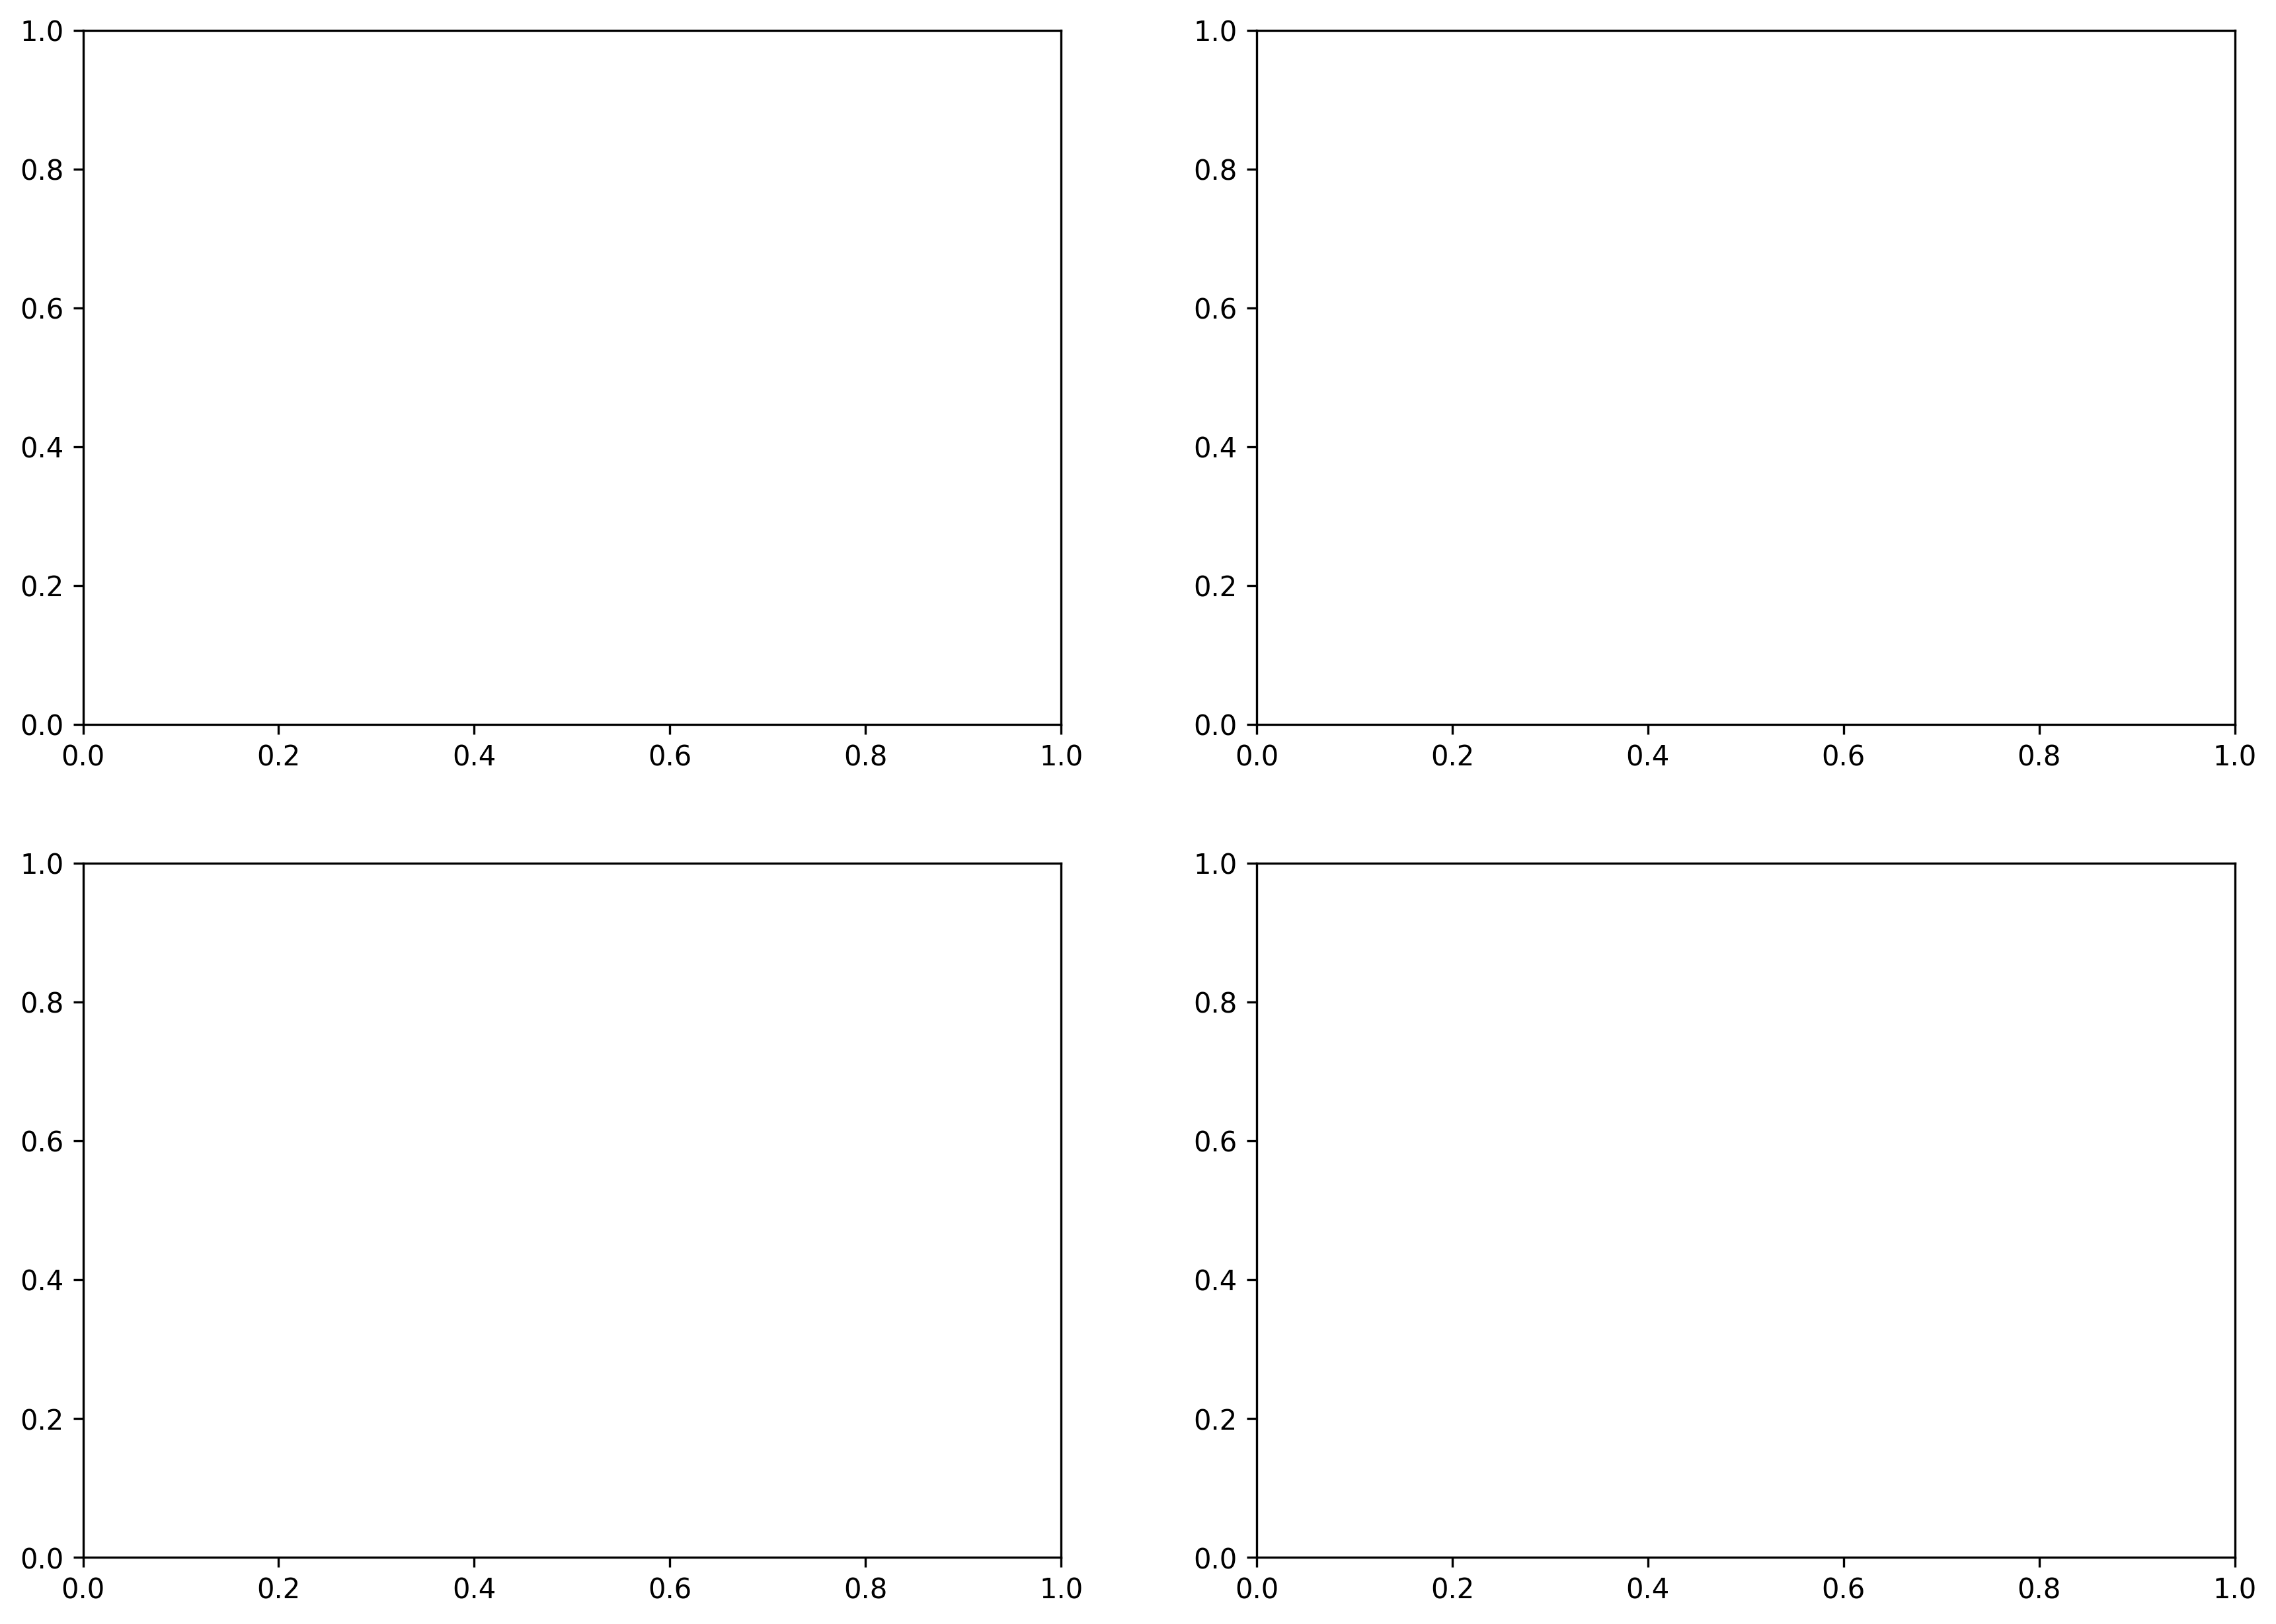

In [ ]:
zero_shot_predictions = {}

for i, (id_str, sample) in enumerate(dev_data.items(), 1):
    prompt = build_zero_shot_prompt(sample)
    pred = get_model_prediction(prompt)
    zero_shot_predictions[id_str] = pred

    print(f"[{i}/{len(dev_data)}] Sample {id_str} done, prediction: {pred} at {datetime.now().strftime('%H:%M:%S')}")

# Use the updated evaluate function
results = evaluate(zero_shot_predictions, dev_data)


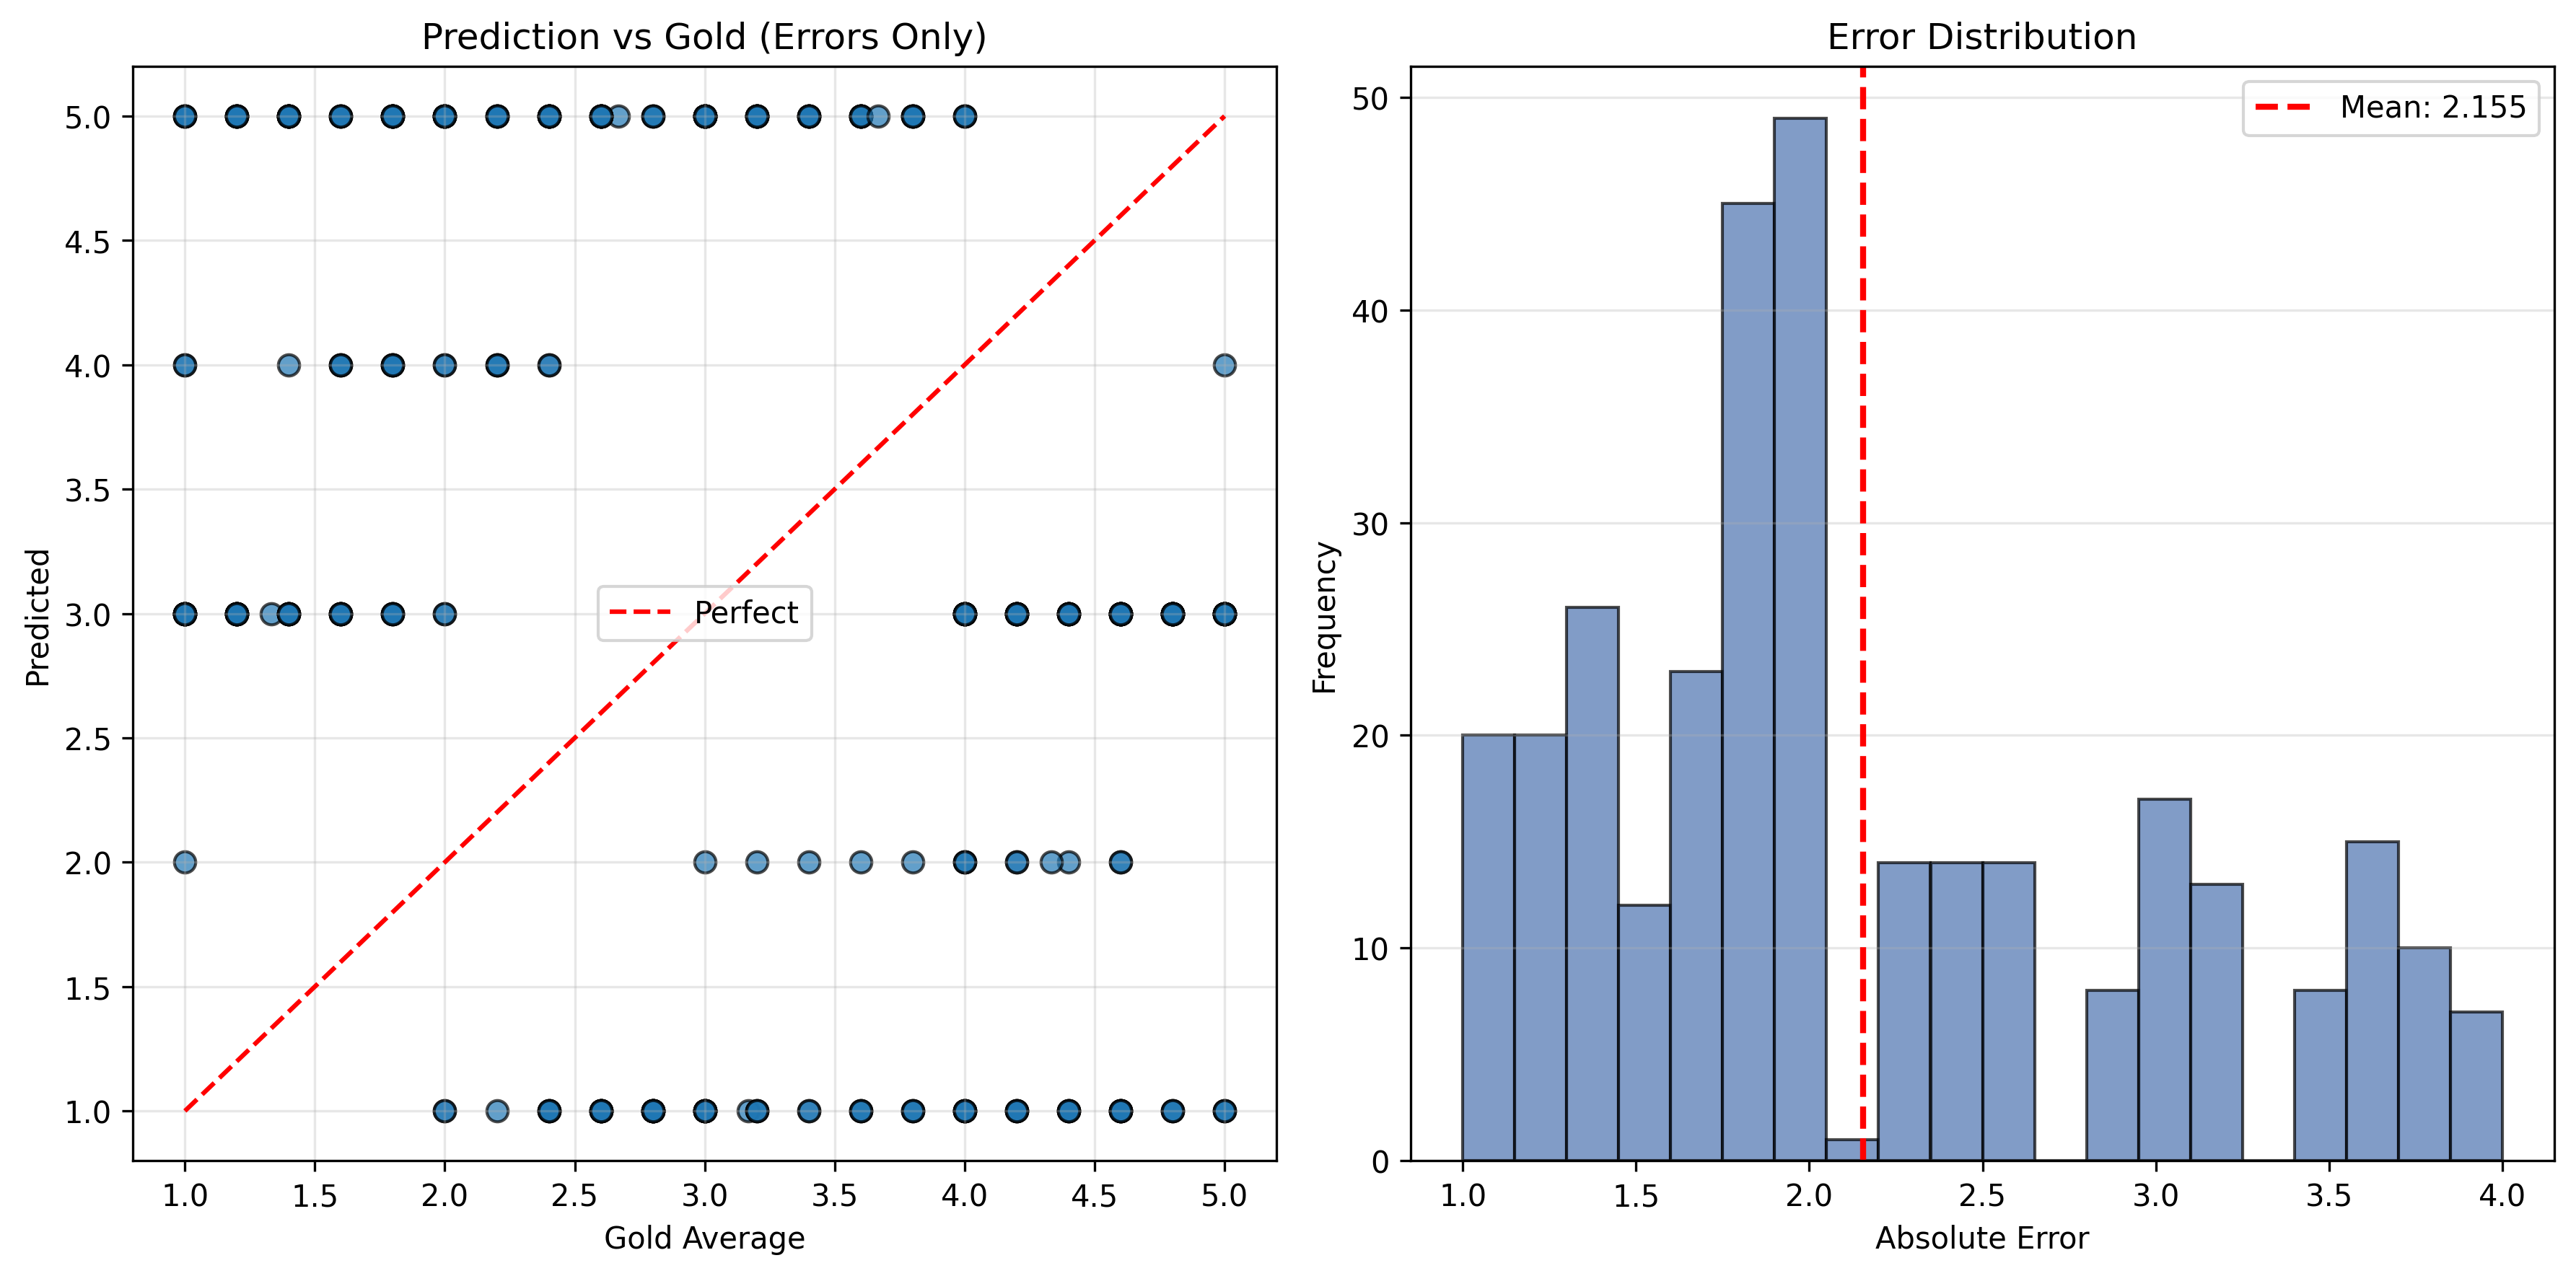

Zero-shot predictions complete! Results saved to results/zero_shot_results.json
Spearman: 0.1072, Accuracy: 0.4626, MAE: 1.4218, MSE: 3.0716


In [ ]:

# Plot errors/corrections
plot_corrections(results['errors'])

# Save predictions
with open("results/zero_shot_results.json", "w") as f:
    json.dump(zero_shot_predictions, f)

print("Zero-shot predictions complete! Results saved to results/zero_shot_results.json")
print(f"Spearman: {results['spearman']:.4f}, Accuracy: {results['accuracy_within_std']:.4f}, MAE: {results['mae']:.4f}, MSE: {results['mse']:.4f}")
